In [ ]:
# most_cor_pairs = [] #pairs with highest positive corr for each stock
# inv_cor_pairs = [] #pairs with highest negative corr for each stock
# for ticker in corr_matrix:
#     second_in_pair = corr_matrix[ticker].sort_values().index[-2]
#     most_cor_pairs.append([ticker, second_in_pair, corr_matrix[ticker].sort_values()[-2]])
#     second_in_pair = corr_matrix[ticker].sort_values().index[0]
#     inv_cor_pairs.append([ticker, second_in_pair, corr_matrix[ticker].sort_values()[0]])

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import yfinance as yf

In [5]:
# Download historical data for all stocks in S&P 500
tickers = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]["Symbol"].tolist()
data = yf.download(tickers, start='2021-03-03', end='2023-02-07', group_by='ticker')
#data = pd.read_csv('data.csv', header = [0,1,2])

[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


Use this cleaning if read from file

In [ ]:
#if read from file
col_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
data.drop(col_drop, axis=1, level=1, inplace = True)
data = data.droplevel(2, axis = 1)
data = data.droplevel(1, axis = 1)
data = data.rename(columns={"Unnamed: 0_level_0": "Date"})
data['Date'] = pd.to_datetime(data['Date'], utc = True)
data.set_index('Date', inplace = True)
data.drop(['BRK.B', 'BF.B'], axis = 1, inplace = True )

Use this cleaning if download from internet

In [6]:
#if download from internet
#Keeping only close price column
col_drop = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
data.drop(col_drop, axis=1, level=1, inplace = True)
data.drop(['BRK.B', 'BF.B'], axis = 1, level=0, inplace = True ) #dropping missing values for 2 stocks
data = data.droplevel( level = 1, axis = 1)

creating correlation matrix and finding best pair for each stock

In [7]:
corr_matrix = data.corr()
#corr_matrix = corr_matrix.droplevel(level = 1, axis =1)
#corr_matrix = corr_matrix.droplevel(level = 1, axis = 0)

In [9]:
most_cor_pairs = {} #pairs with highest positive corr for each stock
inv_cor_pairs = {} #pairs with highest negative corr for each stock
for ticker in corr_matrix:
    second_in_pair = corr_matrix[ticker].sort_values().index[-2]
    most_cor_pairs[ticker+'-'+second_in_pair]= data[[ticker,second_in_pair]]
    second_in_pair = corr_matrix[ticker].sort_values().index[0]
    inv_cor_pairs[ticker+'-'+second_in_pair] = data[[ticker,second_in_pair]]

In [10]:
for keys in most_cor_pairs:
    most_cor_pairs[keys] = most_cor_pairs[keys].rename(columns={most_cor_pairs[keys].columns[0]:'close_1',
                                       most_cor_pairs[keys].columns[1]:'close_2'})

In [11]:
list_most_pairs = list(most_cor_pairs.keys())
list_inv_pairs = list(inv_cor_pairs.keys())


In [ ]:
get_rolling_corr_pair(data, window):
    

In [ ]:
def get_rolling_correlation_matrix(data, window=60):
    # Create an empty correlation matrix
    corr_matrix = np.empty((data.shape[1], data.shape[1], data.shape[1]))
    corr_matrix[:] = np.nan
    flag = 0
    # For each day in the data set
    for i in range(window, len(data)):
        # Get the prices for the rolling window
        prices = data.iloc[i-window:i, :]
        
        # Calculate the correlation matrix for the rolling window
        rolling_corr = prices.corr()
        
        # Save the correlation matrix for this day
        corr_matrix[:, :, i] = rolling_corr

    # Return the entire rolling correlation matrix
    return corr_matrix

def get_best_pair(data, window=60):
    # Get the rolling correlation matrix
    corr_matrix = get_rolling_correlation_matrix(data, window)
    
    # Create a dictionary to store the best pair for each day
    best_pair = {}
    
    # For each day in the data set
    for i in range(window, len(data)):
        # Get the correlation matrix for this day
        corr = corr_matrix[:, :, i]
        
        # Find the pair with the highest correlation
        best_corr = 0
        best_pair_idx = None
        for j in range(corr.shape[0]):
            for k in range(j+1, corr.shape[1]):
                if corr[j, k] > best_corr:
                    best_corr = corr[j, k]
                    best_pair_idx = (j, k)
                    
        # Save the best pair for this day
        best_pair[data.index[i]] = best_pair_idx
        
    return best_pair


In [ ]:
x = get_rolling_correlation_matrix(data, window = 60)

In [12]:
results = {}
open_trades = {}

roll_window = 60
for pair_name, pair_data in most_cor_pairs.items():
    pair_data['spread'] = pair_data['close_1'] - pair_data['close_2']
    #spread_sigma = pair_data['spread'].std()
    spread_rolling = 1*pair_data['spread'].rolling(roll_window).std()
    pair_data['spread_zscore'] = (pair_data['spread'] - 
                                  pair_data['spread'].rolling(roll_window).mean()) / spread_rolling
    trades = []
    last_trades = []
    status = 0
    #if zscore > 1 : sell close 1, buy close 2
    #if zscore < -1 : buy close 1, sell close 2 
    for i in range(1, len(pair_data)):
        #open trade
        
        if pair_data.iloc[i-1]['spread_zscore'] > -1 and pair_data.iloc[i]['spread_zscore'] < -1 and status == 0:
            status = 1
            trade = {
                'direction': 'B/S',
                'open_time': pair_data.index[i],
                'open_price_1': pair_data.iloc[i]['close_1'],
                'open_price_2': pair_data.iloc[i]['close_2'],
                'spread_open': pair_data.iloc[i]['spread'],
                'spread_max': pair_data.iloc[i]['spread'],
                'spread_close': None,
                'close_price_1': None,
                'close_price_2': None,
                'close_time': None,
                'PnL': None,
                'tenor': None
            }
            
        #close trade
        elif pair_data.iloc[i-1]['spread_zscore'] < 0 and pair_data.iloc[i]['spread_zscore'] > 0 and status == 1:
            trade['spread_close'] = pair_data.iloc[i]['spread']
            trade['close_price_1'] = pair_data.iloc[i]['close_1']
            trade['close_price_2'] = pair_data.iloc[i]['close_2']
            trade['close_time'] = pair_data.index[i]
            trade['PnL'] = (((trade['close_price_1'] - trade['open_price_1']) / trade['open_price_1']) +
                            ((trade['open_price_2'] - trade['close_price_2']) / trade['open_price_2']))
            trade['tenor'] = trade['close_time'] - trade['open_time']
            trades.append(trade)
            status = 0
                #long 1 
        # long pnl : (final-initial)/initia
        #open trade
        if pair_data.iloc[i-1]['spread_zscore'] < 1 and pair_data.iloc[i]['spread_zscore'] > 1 and status == 0:
            status = 1
            trade = {
                'direction': 'S/B',
                'open_time': pair_data.index[i],
                'open_price_1': pair_data.iloc[i]['close_1'],
                'open_price_2': pair_data.iloc[i]['close_2'],
                'spread_open': pair_data.iloc[i]['spread'],
                'spread_max': pair_data.iloc[i]['spread'],
                'spread_close': None,
                'close_price_1': None,
                'close_price_2': None,
                'close_time': None,
                'PnL': None,
                'tenor': None
            }
            
        #close trade
        elif pair_data.iloc[i-1]['spread_zscore'] > 0 and pair_data.iloc[i]['spread_zscore'] < 0 and status == 1:
            trade['spread_close'] = pair_data.iloc[i]['spread']
            trade['close_price_1'] = pair_data.iloc[i]['close_1']
            trade['close_price_2'] = pair_data.iloc[i]['close_2']
            trade['close_time'] = pair_data.index[i]
            trade['PnL'] = (((trade['close_price_2'] - trade['open_price_2']) / trade['open_price_2']) +
                ((trade['open_price_1'] - trade['close_price_1']) / trade['open_price_1']))
            trade['tenor'] = trade['close_time'] - trade['open_time']
            trades.append(trade)
            status = 0
    results[pair_name] = pd.DataFrame(trades)
    last_trades.append(trade)
    open_trades[pair_name] = pd.DataFrame(last_trades)
            

In [13]:
summ = []
summary = {}
res = {}
flag = 0
for pair in results:
    if len(results[pair]) > 0:
        res = { 
            'pair': pair,
            'n_trades': len(results[pair]['PnL']),
            'average_pnl': results[pair]['PnL'].mean(),
            'min_pnl': results[pair]['PnL'].min(),
            'max_pnl': results[pair]['PnL'].max(),
            'sum_pnl': results[pair]['PnL'].sum(),
            'avg_yearly_return': results[pair]['PnL'].sum() / 12
            }
    summ.append(res)

In [14]:
summary = pd.DataFrame(summ)

In [15]:
df = pd.DataFrame()

In [16]:
for pair in open_trades:
    open_trades[pair]['pair'] = pair

In [17]:
for pair in most_cor_pairs:
    open_trades[pair]['current_spread'] = most_cor_pairs[pair]['spread'][-1]
    open_trades[pair]['current_z_spread'] = most_cor_pairs[pair]['spread_zscore'][-1]
    

In [ ]:
df = pd.concat(open_trades.values())

In [ ]:
df[['s_1', 's_2']] = df['pair'].apply(lambda x: pd.Series(str(x).split('-')))



In [ ]:
df = df[df['close_price_2'].values == None]

In [22]:
results['DVA-LEN']

KeyError: 'DVA-LEN'

In [ ]:
df.head()

In [ ]:
df['s_diff'] = df['current_spread'] - df['spread_open']

In [ ]:
df.drop(columns = ['spread_close', 'close_price_1', 'close_price_2', 'close_time', 'PnL', 'tenor'], inplace = True)

<AxesSubplot:>

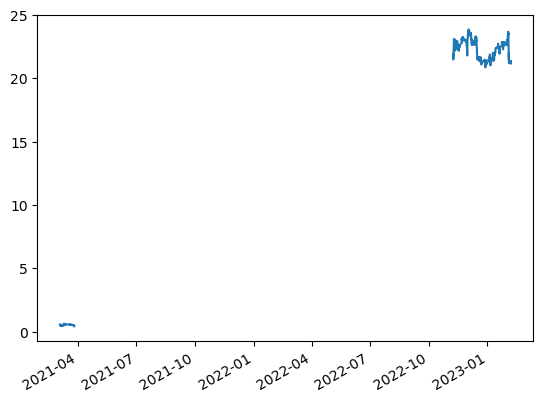

In [27]:
data['GEN'].plot()

In [23]:
results['PSX-GEN']

,direction,open_time,open_price_1,open_price_2,spread_open,spread_max,spread_close,close_price_1,close_price_2,close_time,PnL,tenor
0,B/S,2021-03-16 09:30:00-04:00,85.050003,0.584101,84.465902,84.465902,84.465902,85.050003,0.584101,2021-03-16 09:30:00-04:00,0.000000,0 days 00:00:00
1,B/S,2021-03-25 09:30:00-04:00,80.446602,0.447299,79.999303,79.999303,83.719997,106.504997,22.785000,2022-11-21 09:30:00-05:00,49.615159,606 days 01:00:00
2,S/B,2022-11-22 09:30:00-05:00,111.889999,23.070000,88.820000,88.820000,86.987501,110.180000,23.192499,2022-11-23 10:30:00-05:00,0.020593,1 days 01:00:00
3,S/B,2022-12-19 10:30:00-05:00,101.720001,21.650000,80.070002,80.070002,78.338001,99.888000,21.549999,2022-12-19 13:30:00-05:00,0.013391,0 days 03:00:00
4,S/B,2022-12-20 09:30:00-05:00,102.026703,21.549999,80.476704,80.476704,78.409098,99.504097,21.094999,2022-12-22 12:30:00-05:00,0.003611,2 days 03:00:00
5,S/B,2022-12-23 09:30:00-05:00,103.449997,21.290001,82.159996,82.159996,80.964998,102.349998,21.385000,2023-01-03 11:30:00-05:00,0.015095,11 days 02:00:00
6,B/S,2023-01-03 13:30:00-05:00,100.915398,21.549999,79.365398,79.365398,81.724998,102.794998,21.070000,2023-01-05 12:30:00-05:00,0.040899,1 days 23:00:00
7,S/B,2023-01-06 09:30:00-05:00,105.900002,21.110001,84.790001,84.790001,81.160002,103.150002,21.990000,2023-01-09 11:30:00-05:00,0.067654,3 days 02:00:00
8,B/S,2023-01-10 10:30:00-05:00,100.720001,21.375000,79.345001,79.345001,81.490002,103.440002,21.950001,2023-01-12 10:30:00-05:00,0.000105,2 days 00:00:00
9,S/B,2023-01-18 09:30:00-05:00,105.389999,22.481800,82.908199,82.908199,80.950001,103.375000,22.424999,2023-01-18 11:30:00-05:00,0.016593,0 days 02:00:00


In [ ]:
open_book = df.sort_values('open_time', ascending = False)[1:11]
open_book = open_book.reset_index()

In [ ]:
open_book.drop([5,6], inplace = True)

In [ ]:
open_book

In [ ]:
def update_book(df):
    cur_close_1_list = list(df['s_1'])
    cur_close_2_list = list(df['s_2'])
    cur_close_1_px

In [ ]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

print(get_current_price('TSLA','MSFT'))

In [ ]:
ticker = yf.Ticker('AAPL')
todays_data = ticker.history(period='1d')
todays_data

In [19]:
summary.sort_values('avg_yearly_return', ascending = False)[:20]

,pair,n_trades,average_pnl,min_pnl,max_pnl,sum_pnl,avg_yearly_return
131,AME-GEN,16,3.244738,-0.125815,51.852582,51.915802,4.326317
263,SJM-GEN,8,6.470131,-0.102065,51.764250,51.761048,4.313421
289,PCG-GEN,7,7.237735,-0.091903,50.674006,50.664143,4.222012
134,DXCM-GEN,10,5.050079,-0.116787,50.572036,50.500790,4.208399
221,MDLZ-GEN,8,6.291246,-0.051785,50.310578,50.329970,4.194164
381,YUM-GEN,11,4.529224,-0.054378,49.782423,49.821468,4.151789
496,PSX-GEN,11,4.526827,0.000000,49.615159,49.795093,4.149591
38,NUE-GEN,7,7.076946,-0.083415,49.723737,49.538619,4.128218
398,MRK-GEN,6,8.177549,-0.051594,49.181908,49.065293,4.088774
499,PAYX-GEN,11,4.387694,-0.124586,48.230365,48.264634,4.022053


In [ ]:
pos = 0
pos_ret = 0 
neg = 0
neg_ret = 0
for i in summary['avg_yearly_return']:
    if i < 0 :
        neg += 1
        neg_ret += i
    else:
        pos += 1
        pos_ret += i
pos

In [ ]:
neg

<AxesSubplot:ylabel='Frequency'>

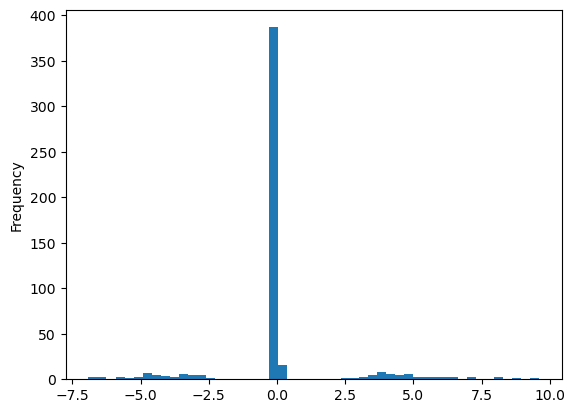

In [21]:
summary['average_pnl'].plot.hist(bins = 50)

In [ ]:
sum_of_sum

In [ ]:
summary.sort_values('avg_yearly_return', ascending = True)

In [ ]:
  app.connect("127.0.0.1", args.port, clientId='DU6768946')

In [ ]:
# Gist example of IB wrapper ...
#
# Download API from http://interactivebrokers.github.io/#
#
# Install python API code /IBJts/source/pythonclient $ python3 setup.py install
#
# Note: The test cases, and the documentation refer to a python package called IBApi,
#    but the actual package is called ibapi. Go figure.
#
# Get the latest version of the gateway:
# https://www.interactivebrokers.com/en/?f=%2Fen%2Fcontrol%2Fsystemstandalone-ibGateway.php%3Fos%3Dunix
#    (for unix: windows and mac users please find your own version)
#
# Run the gateway
#
# user: edemo
# pwd: demo123
#
# Now I'll try and replicate the time telling example


from ibapi.wrapper import EWrapper
from ibapi.client import EClient
from threading import Thread
import queue

class TestWrapper(EWrapper):
    """
    The wrapper deals with the action coming back from the IB gateway or TWS instance
    We override methods in EWrapper that will get called when this action happens, like currentTime
    """

    ## error handling code
    def init_error(self):
        error_queue=queue.Queue()
        self._my_errors = error_queue

    def get_error(self, timeout=5):
        if self.is_error():
            try:
                return self._my_errors.get(timeout=timeout)
            except queue.Empty:
                return None

        return None


    def is_error(self):
        an_error_if=not self._my_errors.empty()
        return an_error_if

    def error(self, id, errorCode, errorString):
        ## Overriden method
        errormsg = "IB error id %d errorcode %d string %s" % (id, errorCode, errorString)
        self._my_errors.put(errormsg)

    ## Time telling code
    def init_time(self):
        time_queue=queue.Queue()
        self._time_queue = time_queue

        return time_queue

    def currentTime(self, time_from_server):
        ## Overriden method
        self._time_queue.put(time_from_server)


class TestClient(EClient):
    """
    The client method
    We don't override native methods, but instead call them from our own wrappers
    """
    def __init__(self, wrapper):
        ## Set up with a wrapper inside
        EClient.__init__(self, wrapper)

    def speaking_clock(self):
        """
        Basic example to tell the time
        :return: unix time, as an int
        """

        print("Getting the time from the server... ")

        ## Make a place to store the time we're going to return
        ## This is a queue
        time_storage=self.wrapper.init_time()

        ## This is the native method in EClient, asks the server to send us the time please
        self.reqCurrentTime()

        ## Try and get a valid time
        MAX_WAIT_SECONDS = 10

        try:
            current_time = time_storage.get(timeout=MAX_WAIT_SECONDS)
        except queue.Empty:
            print("Exceeded maximum wait for wrapper to respond")
            current_time = None

        while self.wrapper.is_error():
            print(self.get_error())

        return current_time

class TestApp(TestWrapper, TestClient):
    def __init__(self, ipaddress, portid, clientid):
        TestWrapper.__init__(self)
        TestClient.__init__(self, wrapper=self)

        self.connect(ipaddress, portid, clientid)

        thread = Thread(target = self.run)
        thread.start()

        setattr(self, "_thread", thread)

        self.init_error()


if __name__ == '__main__':
    ##
    ## Check that the port is the same as on the Gateway
    ## ipaddress is 127.0.0.1 if one same machine, clientid is arbitrary

    app = TestApp("127.0.0.1", 7497, 'DU6768946')

    current_time = app.speaking_clock()

    print(current_time)

    app.disconnect()

In [ ]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class PortfolioInformation(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        EWrapper.__init__(self)
    
    def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
        """ Callback function to retrieve account summary information """
        print("Account:", account)
        print("Tag:", tag)
        print("Value:", value)
        print("Currency:", currency)
        print("\n")

if __name__ == "__main__":
    # Initialize client and connect to the server
    client = PortfolioInformation()
    client.connect("127.0.0.1", 7497, 'DU6768946')
    
    # Request account summary information
    client.reqAccountSummary(1, "All", "AccountType")

    # Start the event loop
    try:
        client.run()
    except Exception as e:
        print("Error:", e)


In [ ]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract

class PortfolioInformation(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self,self)
        EWrapper.__init__(self)
    
    def position(self, account: str, contract: Contract, position: float, avgCost: float):
        """ Callback function to retrieve positions information """
        print("Account:", account)
        print("Symbol:", contract.symbol)
        print("SecType:", contract.secType)
        print("Currency:", contract.currency)
        print("Position:", position)
        print("Avg Cost:", avgCost)
        print("\n")

if __name__ == "__main__":
    # Initialize client and connect to the server
    client = PortfolioInformation()
    client.connect("127.0.0.1", 7497, 'DU6768946')
    
    # Request positions information
    client.reqPositions()

    # Start the event loop
    try:
        client.run()
    except Exception as e:
        print("Error:", e)
